# Analyzing the result of the model error experiment

In [237]:
import warnings
warnings.filterwarnings('ignore') 

import os
import json

path = '../../dgym-data/analysis/noise/selection_noise'
files = [
    f'{path}/{file}' for file in os.listdir(path)
    if file.endswith('.json')
]

In [116]:
from tqdm.auto import tqdm

records = []
for file in tqdm(files):
    
    try:
        result = json.load(open(file, 'r'))
    except:
        continue
    result = result[0] if isinstance(result, list) else result
    
    cost = len(pd.DataFrame(result['annotations']).reindex(columns=['Step Tested']).dropna())
    record = {'sigma': result['sigma'], 'cost': cost}

    if 'outcome' in result.keys():
        record.update({'outcome': result['outcome']})
        records.append(record)
    else:
        record.update({'outcome': 0})
        records.append(record)
        
records = pd.DataFrame(records)

  0%|          | 0/1050 [00:00<?, ?it/s]

<Axes: xlabel='cost', ylabel='outcome'>

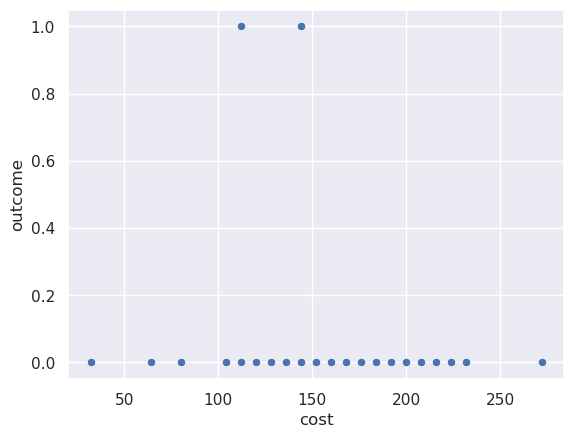

In [144]:
sns.scatterplot(
    records.query('sigma == 2.0'),
    x='cost', y='outcome',
)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='sigma', ylabel='outcome'>

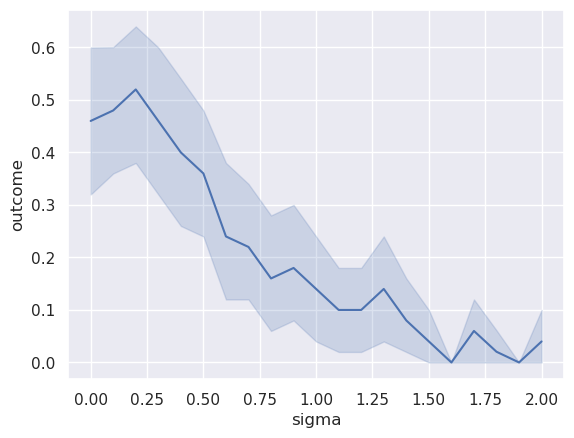

In [150]:
sns.lineplot(records, x='sigma', y='outcome')

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='cost', ylabel='Proportion'>

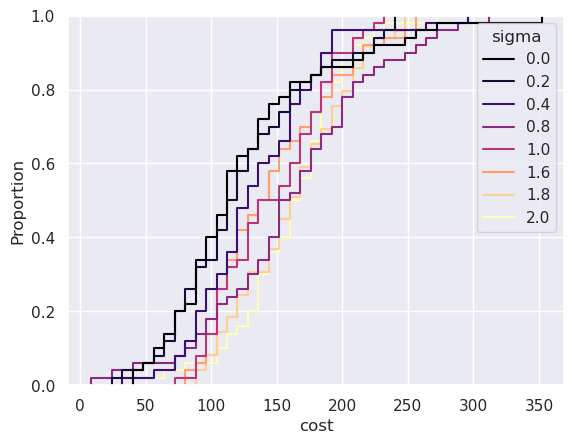

In [126]:
sns.ecdfplot(
    records.query('sigma % 0.2 == 0'),
    hue='sigma', x='cost',
    palette='magma'
)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='sigma', ylabel='outcome'>

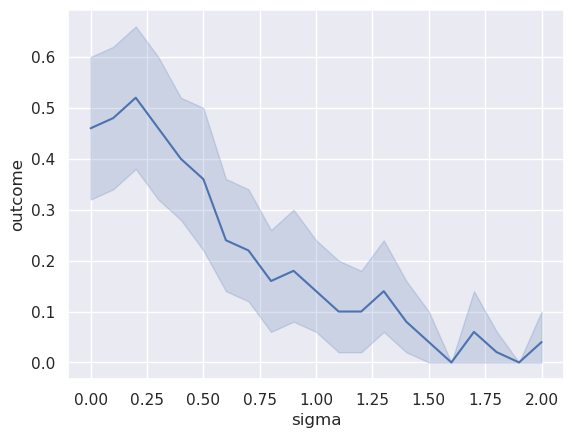

In [98]:
import seaborn as sns

sns.set()
sns.lineplot(records, x='sigma', y='outcome')

In [207]:
colormap = sns.palettes.get_colormap('magma')

In [226]:
colors = colormap.resampled(len(records.groupby('sigma')))

In [316]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Determine the maximum cost to extend the eCDF
max_cost = records['cost'].max()
timeline = np.linspace(0, max_cost, 3_000)

ecdfs = []
for idx, (sigma, group) in enumerate(records.groupby('sigma')):
    
    # if idx % 4 == 0:

    # Create Kaplan-Meier object
    kmf = KaplanMeierFitter()

    # Fit data
    kmf.fit(durations=group['cost'], event_observed=group['outcome'], timeline=timeline)
    survival_function = kmf.survival_function_.reset_index()

    # Transform survival function to eCDF
    ecdf = 1 - kmf.survival_function_
    ecdf['σ'] = sigma
    ecdfs.append(ecdf.reset_index())

<Figure size 3000x1500 with 0 Axes>

Text(0.5, 1.0, 'Cumulative probability of success versus model error ($\\sigma$)')

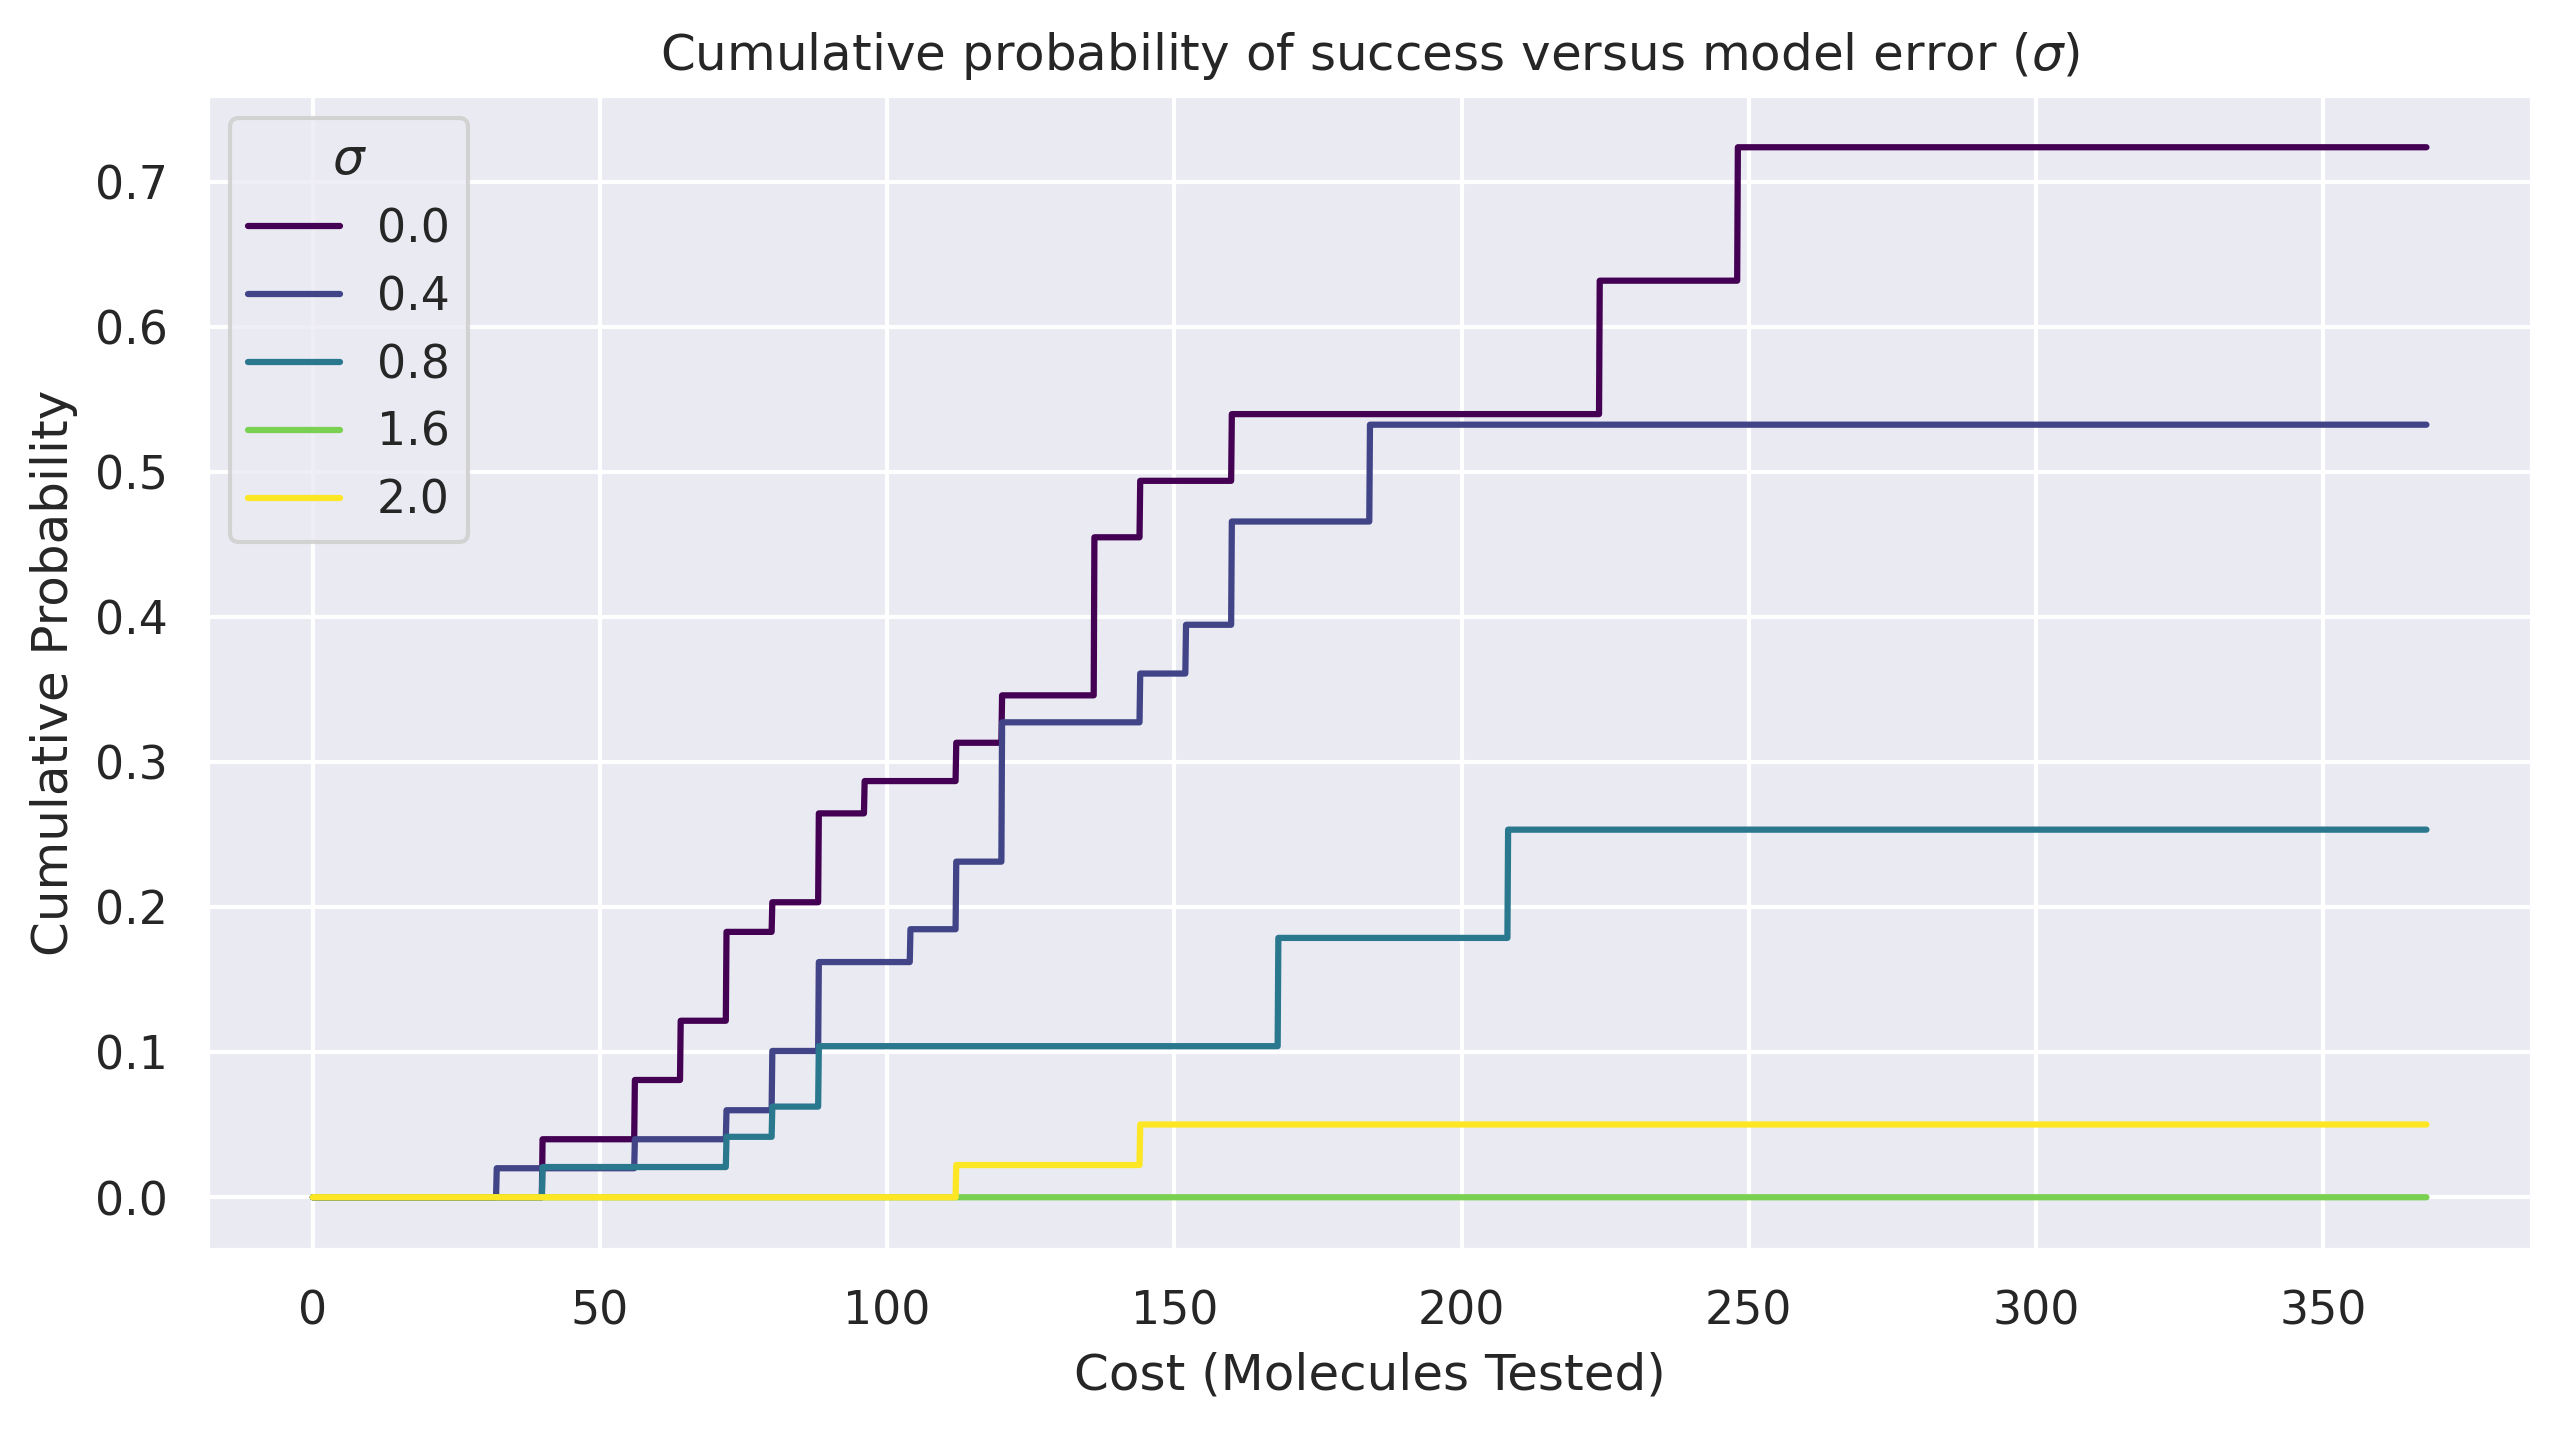

In [327]:
plt.figure(figsize=(10, 5), dpi=300)

g = sns.lineplot(
    pd.concat(ecdfs).query('σ % 0.4 == 0'),
    x='timeline',
    y='KM_estimate',
    hue='σ',
    palette='viridis'
)

plt.legend(title='$\sigma$')
plt.xlabel('Cost (Molecules Tested)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative probability of success versus model error ($\sigma$)')